In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

/Users/chanmunfai/opt/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
train = pd.read_csv("/Users/chanmunfai/fastai/courses/ml1/pubg-finish-placement-prediction/pubg_train_clean.csv", low_memory = False)

In [5]:
train.drop(['Unnamed: 0'], axis =1, inplace=True)

In [6]:
os.makedirs('tmp', exist_ok=True)
train.to_feather('tmp/pubg-train')

In [8]:
train = pd.read_feather('tmp/pubg-train')

In [9]:
test = pd.read_csv("/Users/chanmunfai/fastai/courses/ml1/pubg-finish-placement-prediction/train_V2.csv", low_memory = False)

In [10]:
train.shape, test.shape

((4441677, 45), (4446966, 29))

# Re-running everything 

In [11]:
sample = 500000
df_sample = train.sample(sample)

In [12]:
df, y, nas = proc_df(df_sample, 'winPlacePerc')

In [13]:
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()

val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# Check dimensions of samples
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 44) Sample target shape:  (440000,) Sample validation shape:  (60000, 44)


In [14]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

# Function to print the MAE (Mean Absolute Error) score
# This is the metric used by Kaggle in this competition
def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid),
           'R square train:', m.score(X_train, y_train), 
           'R square val:', m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [15]:
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
%time m1.fit(X_train, y_train)
print_score(m1)

CPU times: user 1min 1s, sys: 860 ms, total: 1min 2s
Wall time: 18.5 s
['mae train: ', 0.04318012711185282, 'mae val: ', 0.06504090031465491, 'R square train:', 0.9603564680147304, 'R square val:', 0.9123046735686096]


In [16]:
fi = rf_feat_importance(m1, X_train); fi[:30]

,cols,imp
42,totalDistance,0.237591
6,killPlace,0.206936
21,walkDistance,0.193299
1,boosts,0.074667
22,weaponsAcquired,0.071299
5,heals,0.043782
16,rideDistance,0.024662
2,damageDealt,0.021241
10,longestKill,0.020420
11,matchDuration,0.016705


In [17]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

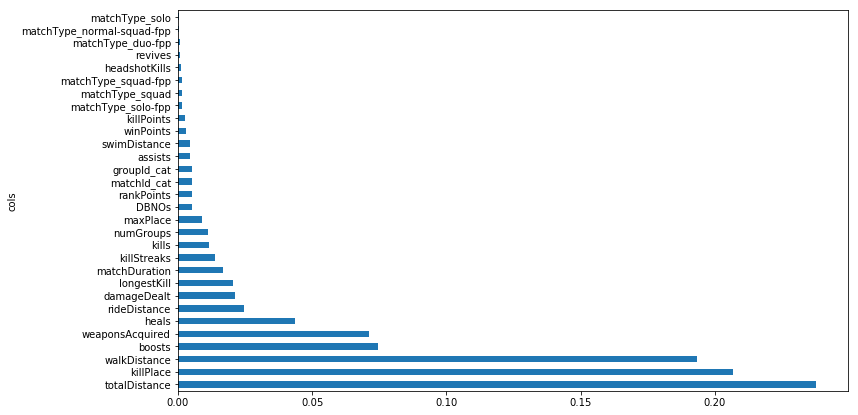

In [18]:
plot_fi(fi[:30]);

In [19]:
to_keep = fi[fi.imp>0.002].cols; len(to_keep)

22

In [20]:
to_keep

42      totalDistance
6           killPlace
21       walkDistance
1              boosts
22    weaponsAcquired
5               heals
16       rideDistance
2         damageDealt
10        longestKill
11      matchDuration
9         killStreaks
8               kills
13          numGroups
12           maxPlace
3               DBNOs
14         rankPoints
41        matchId_cat
40        groupId_cat
0             assists
18       swimDistance
23          winPoints
7          killPoints
Name: cols, dtype: object

In [22]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)
X_train.shape, X_valid.shape

((440000, 22), (60000, 22))

In [ ]:
m2 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features= 'sqrt',
                          n_jobs=-1, oob_score=True)
%time m2.fit(X_train, y_train)
print_score(m2)

In [23]:
to_drop = ['maxPlace']
df_keep2 = df_keep.drop(to_drop, axis =1).copy()
X_train, X_valid = split_vals(df_keep2, n_trn)

In [ ]:
m3 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features= 'sqrt',
                          n_jobs=-1, oob_score=True)
%time m3.fit(X_train, y_train)
print_score(m3)

Let us try removing total Distance as well as it is simply a linear function of walkDistance, swimDistance and vehicleDistance.

In [24]:
to_drop = ['totalDistance']
df_keep2 = df_keep.drop(to_drop, axis =1).copy()
X_train, X_valid = split_vals(df_keep2, n_trn)

In [ ]:
m4 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features= 'sqrt',
                          n_jobs=-1, oob_score=True)
%time m4.fit(X_train, y_train)
print_score(m4)

In [25]:
to_keep_2 = list(df_keep2.columns); len(to_keep_2)

21

In [27]:
np.save('tmp/pubg_cols.npy', np.array(to_keep_2))

In [30]:
keep_cols = np.load('tmp/pubg_cols.npy'); len(keep_cols)

21

In [34]:
df, y, nas = proc_df(train, 'winPlacePerc')

val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * len(train)) 
n_trn = len(df)-n_valid

In [36]:
df = train[keep_cols]; df.shape

(4441677, 21)

In [37]:
raw_train, raw_valid = split_vals(train, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# Check dimensions of sets
print('Train shape: ', X_train.shape, 
      'Target shape: ', y_train.shape, 
      'Validation shape: ', X_valid.shape)

Train shape:  (3908676, 21) Target shape:  (3908676,) Validation shape:  (533001, 21)


In [38]:
set_rf_samples(50000)
# reset_rf_samples()

In [39]:
m5 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
%time m5.fit(X_train, y_train)
print_score(m5)

CPU times: user 14min 59s, sys: 9.02 s, total: 15min 8s
Wall time: 4min 26s
['mae train: ', 0.03791246904148556, 'mae val: ', 0.05993470416827441, 'R square train:', 0.9689828302609254, 'R square val:', 0.9249041707765873]


In [40]:
m6 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
%time m6.fit(X_train, y_train)
print_score(m6)

CPU times: user 29min 34s, sys: 12.3 s, total: 29min 47s
Wall time: 7min 44s
['mae train: ', 0.03769583539898888, 'mae val: ', 0.059710012770823204, 'R square train:', 0.9693820318901885, 'R square val:', 0.925468477081273]


# Submission Script 

#### Making our test set the same format as our training set 

In [ ]:
# One hot encode matchType
test = pd.get_dummies(test, columns=['matchType'])

# Turn groupId and match Id into categorical types
test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')

# Get category coding for groupId and matchID
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes

# Get rid of old columns
test.drop(columns=['groupId', 'matchId'], inplace=True)

In [ ]:
test_pred_1 = test[to_keep_2].copy()
test.shape, test_pred_1.shape

In [ ]:
predicted_win = m4.predict(test_pred_1)

In [ ]:
print(predicted_win)

In [ ]:
sample = pd.read_csv("/Users/chanmunfai/fastai/courses/ml1/pubg-finish-placement-prediction/sample_submission_V2.csv", low_memory = False)

In [ ]:
sample.head()

In [ ]:
pubg_submission1 = pd.DataFrame({'Id': test.Id, 'winPlacePerc': predicted_win})

In [ ]:
pubg_submission1.tail()

In [ ]:
pubg_submission1.to_csv('submission.csv', index=False)